In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from matplotlib import colors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
cadata = sc.read_h5ad('liver_Nature_ZeminZhang_counts_anno.h5ad')

In [5]:
cadata

AnnData object with n_obs × n_vars = 1092172 × 20002
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'percent.mt', 'Cancer_type', 'clusters'
    var: '_index', 'features'

In [17]:
cadata.var_names = cadata.var['features'].copy()

# QC check

In [32]:
#Quality control
cadata.var['mt'] = cadata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(cadata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

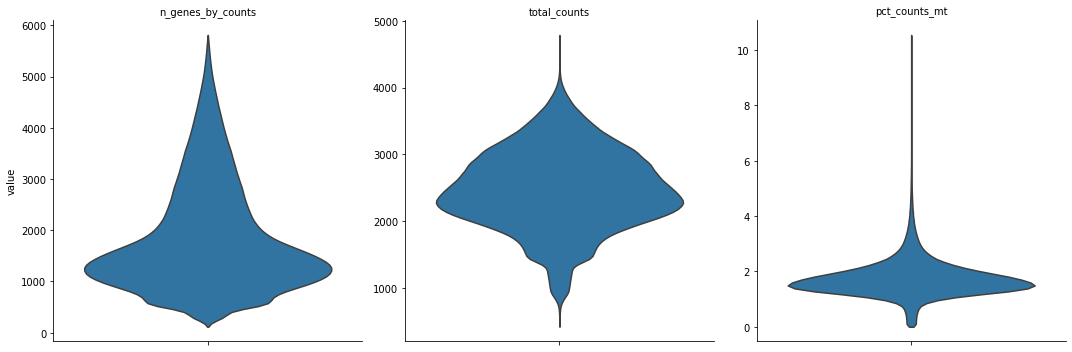

In [33]:
sc.pl.violin(cadata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             stripplot=False, multi_panel=True)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


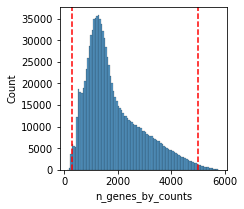

In [34]:
fig, ax = plt.subplots(figsize=(3, 3))
p3 = sns.histplot(cadata.obs['n_genes_by_counts'], kde=False,bins=100)
plt.axvline(x=300,linestyle='--',color='red')
plt.axvline(x=5000,linestyle='--',color='red')

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


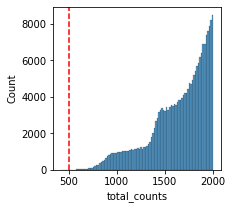

In [37]:
fig, ax = plt.subplots(figsize=(3, 3))
p3 = sns.histplot(cadata.obs['total_counts'][(cadata.obs['total_counts']>50)&(cadata.obs['total_counts']<2000)], kde=False,bins=100)
plt.axvline(x=500,linestyle='--',color='red')

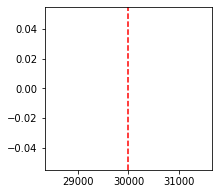

In [38]:
fig, ax = plt.subplots(figsize=(3, 3))
p3 = sns.histplot(cadata.obs['total_counts'][(cadata.obs['total_counts']>10000)&(cadata.obs['total_counts']<60000)],
                  bins=100, kde=False)
plt.axvline(x=30000,linestyle='--',color='red')

In [ ]:
# Low quality data has been filtered in current anndata

# LOY Prediction 

In [9]:
Ychrgenes = ['DDX3Y', 'UTY', 'KDM5D', 'USP9Y', 'ZFY', 'RPS4Y1', 'TMSB4Y', 'EIF1AY', 'NLGN4Y']

In [10]:
import joblib

In [11]:
rf_classifier_loaded = joblib.load('/common/chenx6/public/Pancancer_scRNA/NEW_filter/9YgenesonlyFinalnew_model.pkl')
rf_classifier_loaded

RandomForestClassifier(random_state=42)

In [22]:
set(Ychrgenes).difference(cadata.var_names)

set()

In [24]:
#Obtain expression matrix
X_tumor = cadata[:, Ychrgenes].X.todense()
X_tumor = pd.DataFrame(X_tumor, columns=Ychrgenes, index=cadata.obs.index)

In [25]:
# Use the trained model to predict LOY status on tumor data
tumor_predictions = rf_classifier_loaded.predict(X_tumor)

In [27]:
#Get results and rename
cadata.obs["RL_Prediction_Only9genes"]=tumor_predictions.copy()
cadata.obs['LOY'] = cadata.obs["RL_Prediction_Only9genes"].map({0: 'WTY_SCR', 1: 'LOY_SCR'})
cadata.obs['LOY'].value_counts()

LOY
WTY_SCR    630875
LOY_SCR    461297
Name: count, dtype: int64

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored

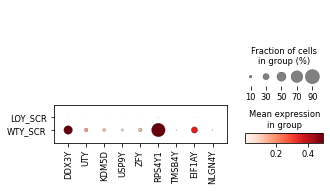

In [28]:
#Model check
sc.pl.dotplot(cadata, Ychrgenes, use_raw=False,groupby='LOY',vmax=0.5)

# LOY percentage calculation

In [23]:
meta = pd.read_excel('clinic_info.xlsx')
meta

,Patient,Gender,Age (years),Cancer_type,Cancer_type_short,Primary_site_of_SLC,Samples for scRNA-seq,No._PB_samples,No._AL_samples,No._tumor_samples,...,AFP_status,CA199 (U/ml),CA199_status,CEA\n(μg/L),CEA_status,Virus,Relapse_state (Yes=0),FPS_time,OS_state (Yes=0),OS_time
0,A001,M,67,Intrahepatic cholangiocarcinoma,ICC,\,A001_ICC,0,0,1,...,1.0,>1000,1.0,86.50,1.0,HBV,0.0,0.900000,0.0,1.000000
1,A002,M,61,Intrahepatic cholangiocarcinoma,ICC,\,A002_ICC,0,0,1,...,1.0,66.9,1.0,5.63,1.0,NBNC,0.0,5.566667,0.0,8.566667
2,A003,F,47,Intrahepatic cholangiocarcinoma,ICC,\,A003_ICC,0,0,1,...,0.0,52.77,1.0,0.98,0.0,NBNC,0.0,26.033333,0.0,26.033333
3,A004,F,49,Intrahepatic cholangiocarcinoma,ICC,\,"A004_ICC, A004_ICC_N",0,1,1,...,0.0,36.25,0.0,2.49,0.0,NBNC,0.0,7.466667,0.0,20.233333
4,A005,F,46,Intrahepatic cholangiocarcinoma,ICC,\,"A005_ICC, A005_ICC_N",0,1,1,...,0.0,8,0.0,2.19,0.0,HBV,1.0,32.566667,1.0,32.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,A120,M,56,Hepatocellular carcinoma,HCC,\,"A120_HCC, A120_HCC_B, A120_HCC_N",1,1,1,...,NaN,NaN,NaN,NaN,NaN,HBV,1.0,13.433333,1.0,13.433333
120,A121,F,46,Hepatocellular carcinoma,HCC,\,"A121_HCC, A121_HCC_B, A121_HCC_N",1,1,1,...,1.0,28.45,0.0,2.80,0.0,NBNC,1.0,13.400000,1.0,13.400000
121,A122,F,65,Hepatocellular carcinoma,HCC,\,"A122_HCC, A122_HCC_B, A122_HCC_N",1,1,1,...,1.0,60.95,1.0,3.97,0.0,HBV,1.0,13.400000,1.0,13.400000
122,A123,M,58,Hepatocellular carcinoma,HCC,\,"A123_HCC, A123_HCC_B, A123_HCC_N",1,1,1,...,0.0,22.35,0.0,2.57,0.0,NBNC,0.0,13.300000,1.0,13.300000


In [62]:
#Calculate cell type proportion in groups
groups = {
    'immune': ['CD4T','CD8T','NK', 'gdT', 'B', 'DC','Mono-like','Mph', 'Neu', 'Mo', 'Mast', 'MonoDC'],
    'Tumor': ['Tumor']
}
pivot_tabletissue = pd.DataFrame()
cadata.obs['Celltype_LOY'] = cadata.obs['Celltype_LOY'].astype('str')
for group in groups.keys():
    sub_obs = cadata.obs.loc[cadata.obs['Celltype'].isin(groups[group]),['Sample', 'Celltype_LOY']]
   
    counts = sub_obs.groupby(['Sample', 'Celltype_LOY']).size().reset_index(name='count')
    
    sub_pivot_tabletissue = counts.pivot_table(index=['Sample'],
                                           columns='Celltype_LOY', values='count', fill_value=0)
    rowsumm = sub_pivot_tabletissue.sum(axis=1)
    sub_pivot_tabletissue = sub_pivot_tabletissue.div(rowsumm,axis='rows')
    
    pivot_tabletissue = pd.concat([pivot_tabletissue, sub_pivot_tabletissue],axis=1)
#Copy meta data
pivot_tabletissue['Sample'] = [samp.split('_')[0] for samp in pivot_tabletissue.index]
pivot_tabletissue['Sex'] = pivot_tabletissue['Sample'].map(dict(zip(meta['Patient'], meta['Gender'])))
pivot_tabletissue['OS'] = pivot_tabletissue['Sample'].map(dict(zip(meta['Patient'], meta['OS_state (Yes=0)'])))
pivot_tabletissue['OS_time'] = pivot_tabletissue['Sample'].map(dict(zip(meta['Patient'], meta['OS_time'])))
pivot_tabletissue['Cancertype'] = [samp.split('_')[1] for samp in pivot_tabletissue.index]
pivot_tabletissue = pivot_tabletissue.loc[pivot_tabletissue['Sex']=='M',:].copy()
#Save
pivot_tabletissue.to_csv('Nature_liver_Zhang_LOY_pct_in_groups.csv')